In [202]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#for preprocessing
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder , LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split , GridSearchCV, cross_val_score

#for evaluation
from sklearn.metrics import accuracy_score, precision_score ,f1_score ,recall_score, classification_report, confusion_matrix


#models for classification
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier

In [203]:
df_matches = pd.read_csv('pl_matches.csv')

In [204]:
columns_to_delete = ['Unnamed: 0', 'date', 'time', 'comp', 'captain', 'attendance', 'match report', 'notes', 'gf', 'ga']
df_matches.drop(columns=columns_to_delete, inplace=True)

In [205]:
df_matches.head()

,round,day,venue,result,opponent,xg,xga,poss,formation,referee,sh,sot,dist,fk,pk,pkatt,season,team
0,Matchweek 2,Mon,Away,W,Wolves,1.9,0.6,65,4-2-3-1,Andre Marriner,13,8,21.1,2,1,1,2024,Manchester City
1,Matchweek 3,Sun,Home,L,Leicester City,0.9,2.9,72,4-2-3-1,Michael Oliver,16,5,19.8,1,0,0,2024,Manchester City
2,Matchweek 4,Sat,Away,D,Leeds United,1.2,2.4,49,4-3-3,Mike Dean,23,1,18.2,1,0,0,2024,Manchester City
3,Matchweek 5,Sat,Home,W,Arsenal,1.3,0.9,58,3-1-4-2,Chris Kavanagh,13,5,17.7,0,0,0,2024,Manchester City
4,Matchweek 6,Sat,Away,D,West Ham,1.0,0.3,69,4-3-3,Anthony Taylor,14,7,20.9,1,0,0,2024,Manchester City


<Axes: >

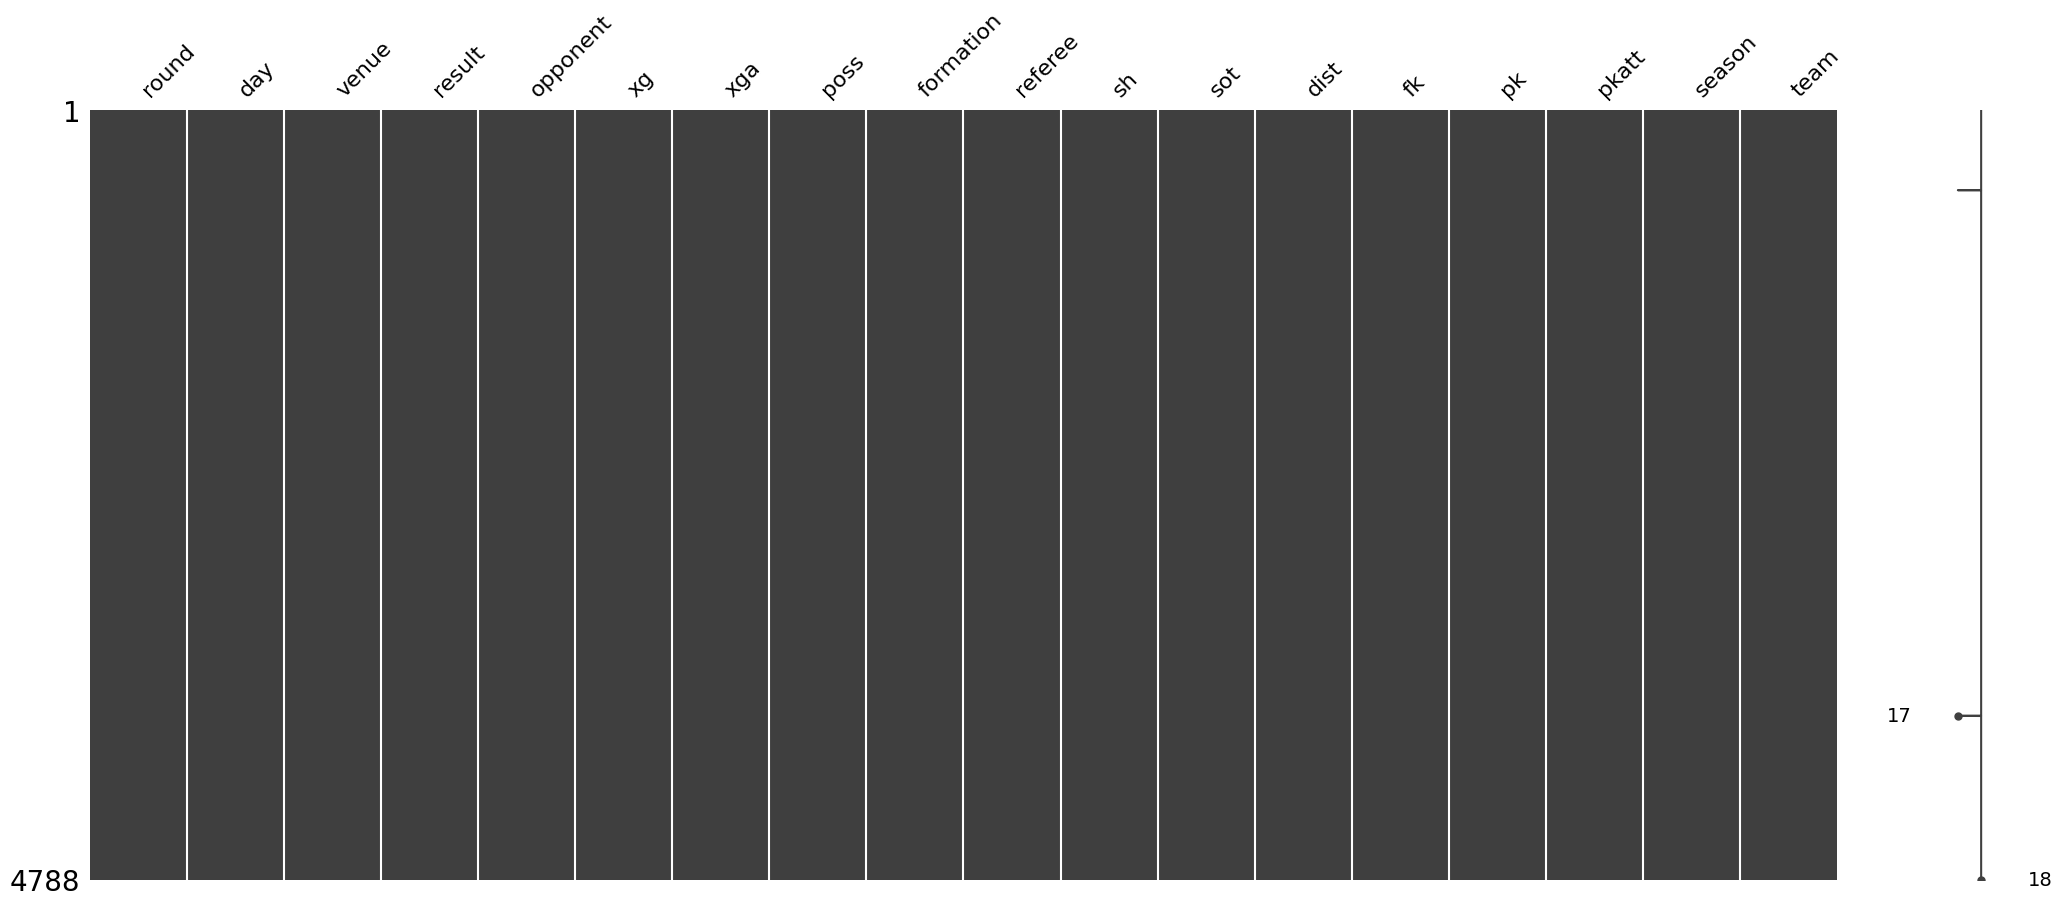

In [206]:
import missingno as msno
msno.matrix(df_matches)

In [207]:
df_matches['round'] = df_matches['round'].apply(lambda x: x.split(' ')[1])
df_matches['round'] = df_matches['round'].astype(int)

day_map = {'Mon': 1, 'Tue': 2, 'Wed': 3, 'Thu': 4, 'Fri': 5, 'Sat': 6, 'Sun': 7}
df_matches['day'] = df_matches['day'].map(day_map)

venue_map = {'Home': 1, 'Away': 0}
df_matches['venue'] = df_matches['venue'].map(venue_map)

result_map = {'W': 3, 'D': 1, 'L': 0}
df_matches['result'] = df_matches['result'].map(result_map)

formation_map = {
    '4-2-3-1': 22,
    '4-3-3': 21,
    '4-4-2': 20,
    '3-4-3': 19,
    '3-5-2': 18,
    '4-1-4-1': 17,
    '4-4-1-1': 16,    
    '3-4-1-2': 15,    
    '5-3-2': 14,    
    '5-4-1': 13,       
    '4-5-1': 12,          
    '4-3-1-2': 11,         
    '4-1-2-1-2◆': 10,      
    '4-2-2-2': 9,         
    '3-1-4-2': 8,         
    '4-3-2-1': 7,         
    '3-2-4-1': 6,         
    '3-3-3-1': 5,         
    '3-5-1-1': 4,         
    '3-4-3◆': 3,          
    '4-1-3-2': 2,          
    '4-2-4-0': 1}
df_matches['formation'] = df_matches['formation'].map(formation_map)

referee_map = {
    'Anthony Taylor' : 34,       
    'Michael Oliver': 33,       
    'Paul Tierney': 32,     
    'Craig Pawson':   31,         
    'Stuart Attwell': 30,      
    'Chris Kavanagh': 29,       
    'Martin Atkinson': 28,      
    'David Coote': 27,          
    'Andre Marriner': 26,
    'Mike Dean': 25,
    'Jonathan Moss': 24,
    'Andy Madley': 23,
    'Simon Hooper': 22,
    'Kevin Friend': 21,
    'Peter Bankes': 20,
    'Robert Jones': 19,
    'Graham Scott': 18,
    'Darren England': 17,
    'Jarred Gillett': 16,
    'John Brooks': 15,
    'Lee Mason': 14,
    'Michael Salisbury': 13,
    'Tim Robinson': 12, 
    'Thomas Bramall': 11,
    'Tony Harrington': 10,
    'Samuel Barrott': 9,
    'Darren Bond': 8,
    'Joshua Smith': 7,
    'Samuel Allison': 6,
    'Oliver Langford': 5,
    'Lewis Smith': 4,
    'Robert Madley': 3,
    'Rebecca Welch': 2,
    'Matt Donohue': 1,
    'Sunny Singh': 0}
df_matches['referee'] = df_matches['referee'].map(referee_map)


nombres_completos = {
    'Manchester Utd': 'Manchester United',
    'Tottenham Hotspur': 'Tottenham',
    'Newcastle Utd': 'Newcastle United',
    'West Ham United': 'West Ham',
    'Sheffield Utd': 'Sheffield United',
    'Nott\'ham Forest': 'Nottingham Forest',
    'Brighton and Hove Albion': 'Brighton',
    'Wolverhampton Wanderers': 'Wolves',
    'West Bromwich Albion': 'West Brom'}

teams_map = {
    'Manchester City':  26,
    'Liverpool':  25,
    'Arsenal':  24,
    'Chelsea':  23,
    'Manchester United':  22,
    'Tottenham':  21,
    'Aston Villa':  20,
    'Brighton':  19,
    'Wolves':  18,
    'Newcastle United':  17,
    'Crystal Palace':  16,
    'Everton':  15,
    'West Ham':  14,
    'Leicester City':  13,
    'Southampton':  12,
    'Burnley':  11,
    'Leeds United':  10,
    'Fulham':  9,
    'Sheffield United':  8,
    'Bournemouth':  7,
    'Brentford':  6,
    'West Brom':  5,
    'Nottingham Forest':  4,
    'Watford':  3,
    'Norwich City':  2,
    'Luton Town':  1}

df_matches['team'] = df_matches['team'].replace(nombres_completos)
df_matches['opponent'] = df_matches['opponent'].replace(nombres_completos)
df_matches['team'] = df_matches['team'].map(teams_map)
df_matches['opponent'] = df_matches['opponent'].map(teams_map)

df_matches.head()

,round,day,venue,result,opponent,xg,xga,poss,formation,referee,sh,sot,dist,fk,pk,pkatt,season,team
0,2,1,0,3,18,1.9,0.6,65,22,26,13,8,21.1,2,1,1,2024,26
1,3,7,1,0,13,0.9,2.9,72,22,33,16,5,19.8,1,0,0,2024,26
2,4,6,0,1,10,1.2,2.4,49,21,25,23,1,18.2,1,0,0,2024,26
3,5,6,1,3,24,1.3,0.9,58,8,29,13,5,17.7,0,0,0,2024,26
4,6,6,0,1,14,1.0,0.3,69,21,34,14,7,20.9,1,0,0,2024,26


In [208]:
df_matches = df_matches.dropna()
X = df_matches.drop(columns='result')
y = df_matches['result']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

models = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'SVC': SVC(random_state=42),
    'KNN': KNeighborsClassifier(),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'AdaBoost': AdaBoostClassifier(random_state=42)}

df_models = []
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    df_models.append([name, accuracy, precision, recall, f1])

df_models = pd.DataFrame(df_models, columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1'])
df_models.sort_values(by='Accuracy', ascending=False)

C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitali

,Model,Accuracy,Precision,Recall,F1
1,Random Forest,0.742171,0.748335,0.742171,0.723025
4,Decision Tree,0.669102,0.664855,0.669102,0.666620
5,Gradient Boosting,0.644050,0.609807,0.644050,0.595175
6,AdaBoost,0.617954,0.557921,0.617954,0.565178
0,Logistic Regression,0.575157,0.505108,0.575157,0.510678
3,KNN,0.529228,0.525186,0.529228,0.516425
2,SVC,0.406054,0.164880,0.406054,0.234529


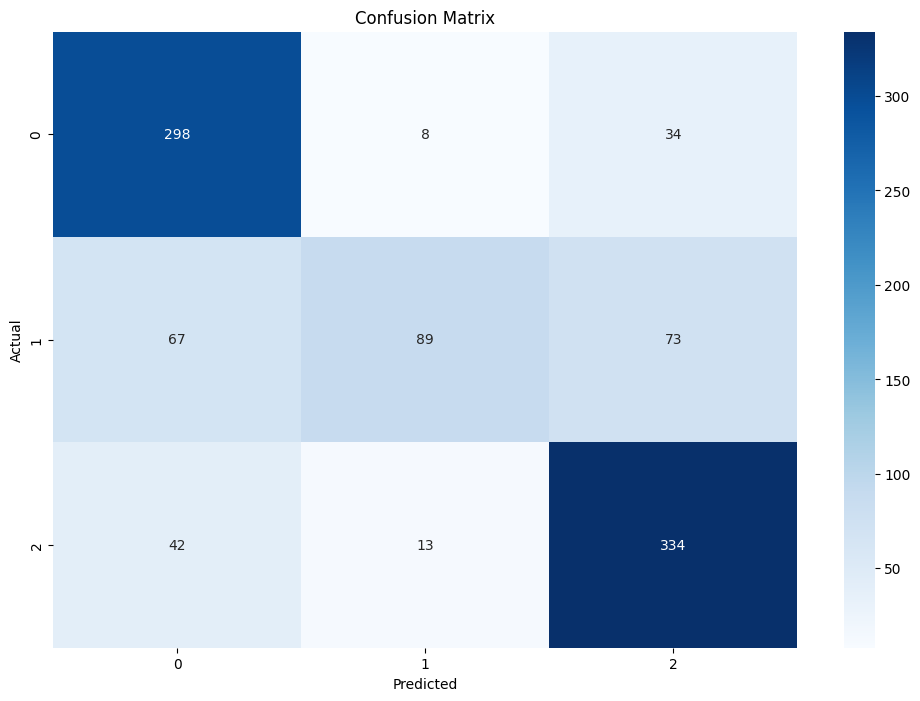

In [209]:
# con este random forest imprime la matriz de confusion
model = RandomForestClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

plt.figure(figsize=(12, 8))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [139]:
param_grid = {
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]}

rf = RandomForestClassifier()
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

print(grid_search.best_params_)
print(grid_search.best_score_)
print(grid_search.best_estimator_)

Fitting 5 folds for each of 180 candidates, totalling 900 fits
{'max_depth': 40, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 400}
0.7241389784808614
RandomForestClassifier(max_depth=40, n_estimators=400)


In [210]:
rf = RandomForestClassifier(max_depth=40, min_samples_leaf=1, min_samples_split=2, n_estimators=400)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

df_results = []
model_name = 'Random Forest (Grid Search)'
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
df_results.append([model_name, accuracy, precision, recall, f1])

df_results = pd.DataFrame(df_results, columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1'])
df_models = pd.concat([df_models, df_results])
df_models.sort_values(by='Accuracy', ascending=False)

,Model,Accuracy,Precision,Recall,F1
0,Random Forest (Grid Search),0.753653,0.765769,0.753653,0.734922
1,Random Forest,0.742171,0.748335,0.742171,0.723025
4,Decision Tree,0.669102,0.664855,0.669102,0.666620
5,Gradient Boosting,0.644050,0.609807,0.644050,0.595175
6,AdaBoost,0.617954,0.557921,0.617954,0.565178
0,Logistic Regression,0.575157,0.505108,0.575157,0.510678
3,KNN,0.529228,0.525186,0.529228,0.516425
2,SVC,0.406054,0.164880,0.406054,0.234529


In [211]:
df_RF_models = df_models.sort_values(by='Accuracy', ascending=False).head(2)
df_RF_models

,Model,Accuracy,Precision,Recall,F1
0,Random Forest (Grid Search),0.753653,0.765769,0.753653,0.734922
1,Random Forest,0.742171,0.748335,0.742171,0.723025


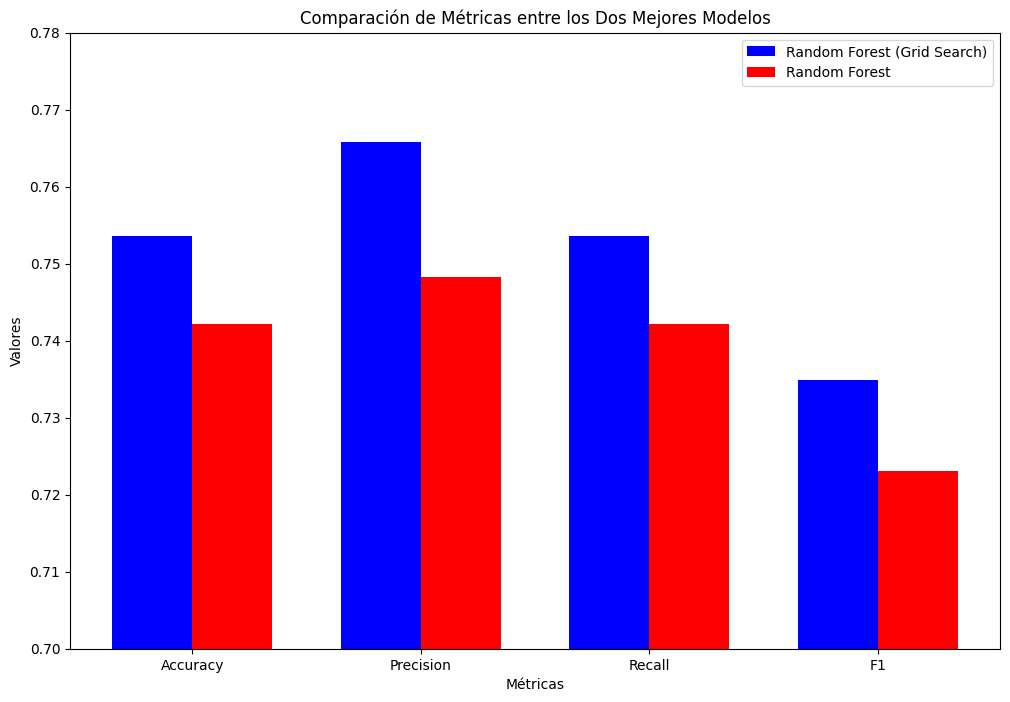

In [212]:
plt.figure(figsize=(12, 8))
bar_width = 0.35
bar_positions = np.arange(len(df_RF_models.columns[1:]))

for i, model in enumerate(df_RF_models['Model']):
    plt.bar(bar_positions + i * bar_width, df_RF_models.loc[df_RF_models['Model'] == model].iloc[0, 1:], 
            bar_width, label=model, color=['blue', 'red'][i])

plt.xlabel('Métricas')
plt.ylabel('Valores')
plt.title('Comparación de Métricas entre los Dos Mejores Modelos')
plt.xticks(bar_positions + bar_width / 2, df_RF_models.columns[1:])
plt.legend()
plt.ylim(0.7, 0.78)
plt.show()

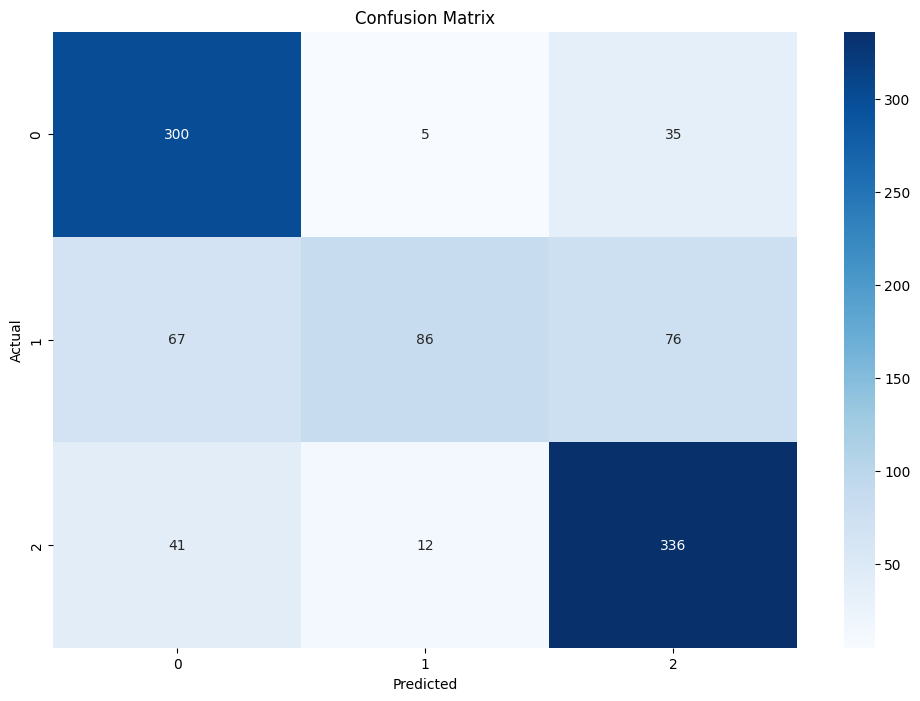

In [213]:
plt.figure(figsize=(12, 8))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()